# Overlap Correction with Linear Models (aka unfold.jl)
### Benedikt Ehinger, Dave Kleinschmidt
### 2020-02-17

In [1]:
using Revise
using CSV
using StatsModels
using MixedModels
using DataFrames
using DataFramesMeta
import DSP
import Plots
import unfold
Plots.gr()

┌ Info: Precompiling unfold [181c99d8-e21b-4ff3-b70b-c233eddec679]
└ @ Base loading.jl:1273
┌ Info: Skipping precompilation since __precompile__(false). Importing unfold [181c99d8-e21b-4ff3-b70b-c233eddec679].
└ @ Base loading.jl:1028
┌ Warning: Package unfold does not have LinearAlgebra in its dependencies:
│ - If you have unfold checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with unfold
│ Loading LinearAlgebra into unfold from project dependency, future warnings for unfold are suppressed.
└ @ nothing nothing:904


Plots.GRBackend()

In [2]:
testCase = "testCase15"
#testCase = "testCaseMultisubject"
data = CSV.read("../test/"*testCase*"_data.csv", header=0)
data = convert(Matrix,data)
data = dropdims(data,dims=1) # convert to vector
evts = CSV.read("../test/"*testCase*"_events.csv");

For now we have to subset the data to contain only event-type. (limitation: We also have to remove some missings)

In [3]:
evts_subset = evts[evts.type.=="stimulus2",:]

# Is it possible to pass Missing Type through? That would be fantastic
evts_subset.continuousA = Missings.disallowmissing(evts_subset.continuousA)
evts_subset.conditionA  = Missings.disallowmissing(evts_subset.conditionA);

In [4]:
showall(first(evts_subset,6,))

┌ Warning: `showall(df::AbstractDataFrame, allcols::Bool=true)` is deprecated, use `show(df, allrows=true, allcols=allcols)` instead.
│   caller = showall(::DataFrame) at deprecated.jl:66
└ @ DataFrames .\deprecated.jl:66


6×7 DataFrame
│ Row │ latency │ type      │ intercept │ continuousA │ conditionA │ splineA  │
│     │ Int64   │ String    │ Int64     │ Float64     │ Int64      │ Float64⍰ │
├─────┼─────────┼───────────┼───────────┼─────────────┼────────────┼──────────┤
│ 1   │ 15      │ stimulus2 │ 1         │ 0.0114375   │ 0          │ missing  │
│ 2   │ 53      │ stimulus2 │ 1         │ 41.9195     │ 0          │ missing  │
│ 3   │ 92      │ stimulus2 │ 1         │ 14.0387     │ 0          │ missing  │
│ 4   │ 131     │ stimulus2 │ 1         │ 8.50442     │ 0          │ missing  │
│ 5   │ 172     │ stimulus2 │ 1         │ 69.1877     │ 0          │ missing  │
│ 6   │ 214     │ stimulus2 │ 1         │ 28.0444     │ 0          │ missing  │

│ Row │ splineB  │
│     │ Float64⍰ │
├─────┼──────────┤
│ 1   │ missing  │
│ 2   │ missing  │
│ 3   │ missing  │
│ 4   │ missing  │
│ 5   │ missing  │
│ 6   │ missing  │

The data has little noise and the underlying signal is a pos-neg spike pattern

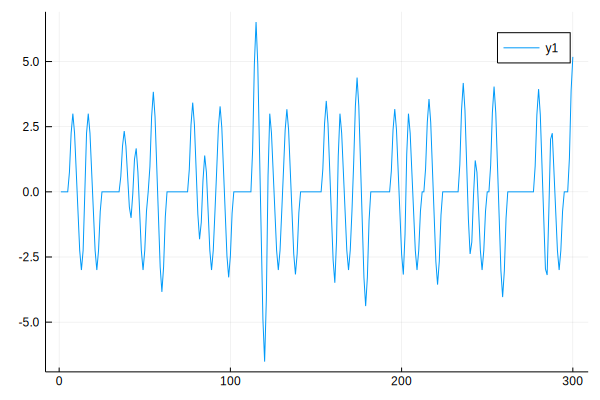

In [5]:
Plots.plot(data[1:300])

## Basis Functions
### HRF / BOLD
We are now ready to define a basisfunction. There are currently only two basisfunction implemented, so not much choice.
We first have a look at the BOLD-HRF basisfunction:

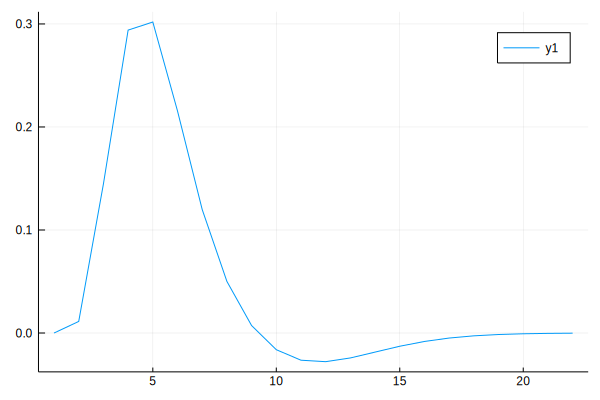

In [6]:
TR = 1.5
bold = unfold.hrfbasis(TR) # using default SPM parameters
eventonset = 1.3
Plots.plot(bold.kernel(eventonset))

Classically, we would convolve this HRF function with a impulse-vector, with impulse at the event onsets

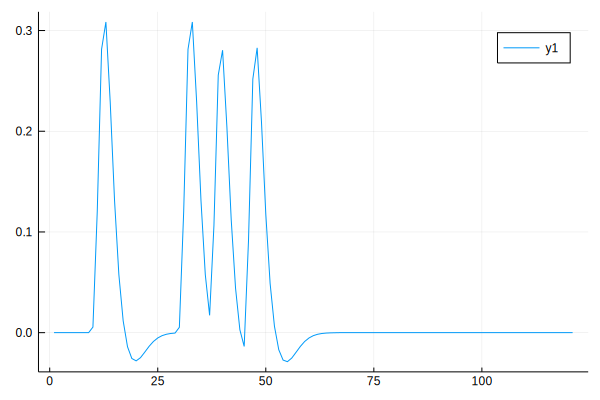

In [7]:
y = zeros(100)
y[[10,30,37,45]] .=1
y_conv = DSP.conv(y,bold.kernel(0))
Plots.plot(y_conv)

Which one would use as a regressor against the recorded BOLD timecourse.

Note that events could fall inbetween TR (the sampling rate). Some packages subsample the time signal, but in `unfold` we can directly call the `bold.kernel` function at a given event-time, which allows for non-TR-multiples to be used.

### FIR Basis Function

Okay, let's have a look at a different basis function: The FIR basisfunction.

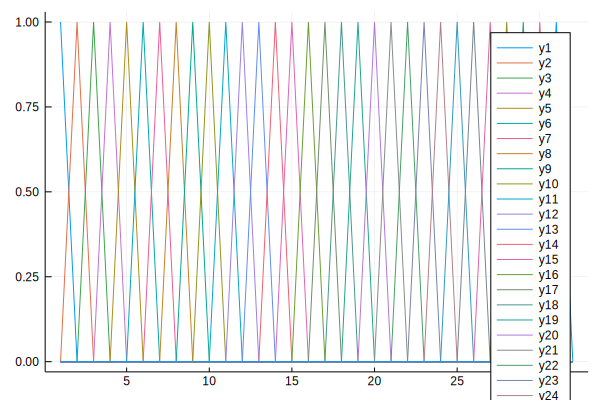

In [8]:
basisfunction = unfold.firbasis(τ=(-0.2,.4),sfreq=50)
Plots.plot(basisfunction.kernel(0))

Not very clear, better show it in 2D

In [9]:
basisfunction.kernel(0)[1:10,1:10]

10×10 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

The FIR basisset consists of multiple basisfunctions. That is, each event will now be *timeexpanded* to multiple predictors, each with a certain time-delay to the event onset.
This allows to model any arbitrary linear overlap shape, and doesn't force us to make assumptions on the convolution kernel (like we had to do in the BOLD case)


## Single Subject ModelFit
We can now define a formula

In [10]:
f  = @formula 0~1+conditionA*continuousA#+(1|subject)

FormulaTerm
Response:
  0
Predictors:
  1
  conditionA(unknown)
  continuousA(unknown)
  conditionA(unknown) & continuousA(unknown)

And fit a `UnfoldLinearModel`

In [11]:
# TODO write the converter to the UnfoldObject
#beta,history =
m = unfold.fit(unfold.UnfoldLinearModel,f,evts_subset,data,basisfunction)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = time_expand(::Array{Float64,2}, ::unfold.TimeExpandedTerm{MatrixTerm{Tuple{InterceptTerm{true},ContinuousTerm{Float64},ContinuousTerm{Float64},InteractionTerm{Tuple{ContinuousTerm{Float64},ContinuousTerm{Float64}}}}}}, ::DataFrame) at designmatrix.jl:149
└ @ unfold C:\Users\behinger\cloud\PostDoc\projects\unmixed\julia\unfold\src\designmatrix.jl:149


UnfoldModel
Unique Terms: SubString{String}["(Intercept)", "conditionA", "continuousA", "conditionA & continuousA"]
Times: -0.2 : 0.4


In [12]:
using Gadfly
using DataFramesMeta
Gadfly.push_theme(:dark)

d = @linq m.results |> where(:group.=="fixed")
plot(d,x=:time,y=:estimate,color=:term,Geom.LineGeometry)

┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1273
(compiled mode) evaluation error starting at C:\Users\behinger\cloud\PostDoc\projects\unmixed\julia\unfold\doc\none:0
  could not open file C:\Users\behinger\cloud\PostDoc\projects\unmixed\julia\unfold\doc\dataframes.jl


Stacktrace:
 [1] include at .\boot.jl:328 [inlined]
 [2] include_relative(::Module, ::String) at .\loading.jl:1105
 [3] include at .\Base.jl:31 [inlined]
 [4] include at C:\Users\behinger\.julia\packages\Gadfly\ISHWw\src\Gadfly.jl:1 [inlined]
 [5] link_dataframes() at C:\Users\behinger\.julia\packages\Gadfly\ISHWw\src\mapping.jl:238
 [6] top-level scope at C:\Users\behinger\.julia\packages\IJulia\yLI42\src\kernel.jl:52
while evaluating
begin
    link_dataframes()
    __pkguuid__ = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
end
in module Gadfly


# TODO plotting

In [ ]:
using Weave

# convert to html
weave("doc\\lm_tutorial.jmd")

# convert to a python notebook
convert_doc("doc\\lm_tutorial.jmd", "doc\\lm_tutorial.ipynb")

# convert to md for README
weave("doc\\lm_tutorial.jmd", doctype="pandoc", out_path = "README.md")